# Imports

In [7]:
import glob
import os
import pandas as pd 
import numpy as np 
import regex as re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import datetime as dt
import tensorflow as tf
import warnings
from sklearn.preprocessing import MinMaxScaler 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
warnings.filterwarnings('ignore')
from matplotlib.dates import DateFormatter

# Load data

In [8]:
df = pd.read_csv('./new_final.csv')

In [9]:
df.head()

,Month,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
0,2017-01,2.1,118.06,4.6,144
1,2017-02,2.0,118.34,4.6,166
2,2017-03,3.8,118.02,4.5,194
3,2017-04,6.0,119.10,4.4,169
4,2017-05,6.3,119.38,4.4,169


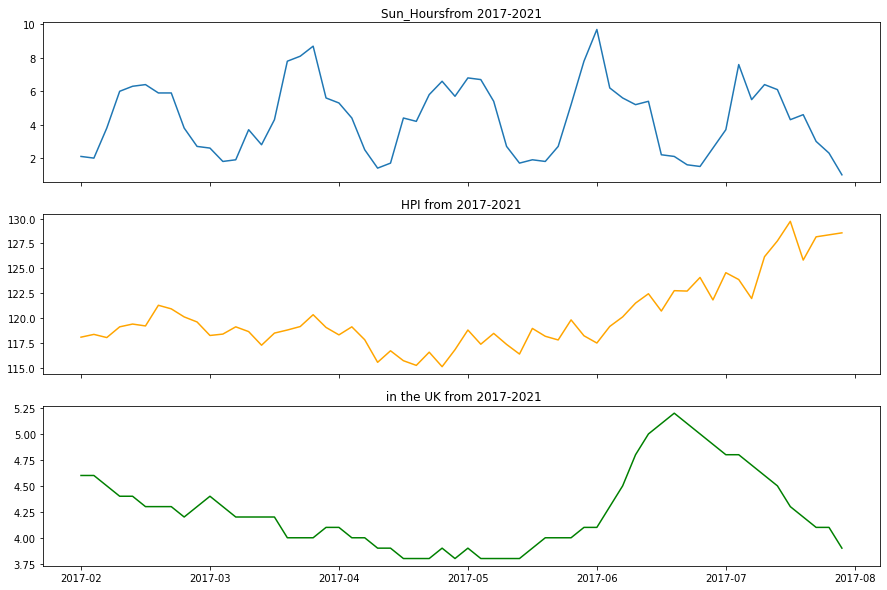

In [10]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(15,10))
df['Sun_Hours'].plot(title=df.columns[1]+' from 2017-2021',ax=ax[0])
df['HPI'].plot(title=df.columns[2]+' from 2017-2021',ax=ax[1],color='orange')
df['Unemployment_Rate'].plot(title=' in the UK from 2017-2021',ax=ax[2],color='green')
ax[2].set_xticklabels(df['Month']); 
plt.gcf().set_facecolor('white');

### Check autocorrelation of the time series data
##### We can see that we are dealing with a stationary time series.

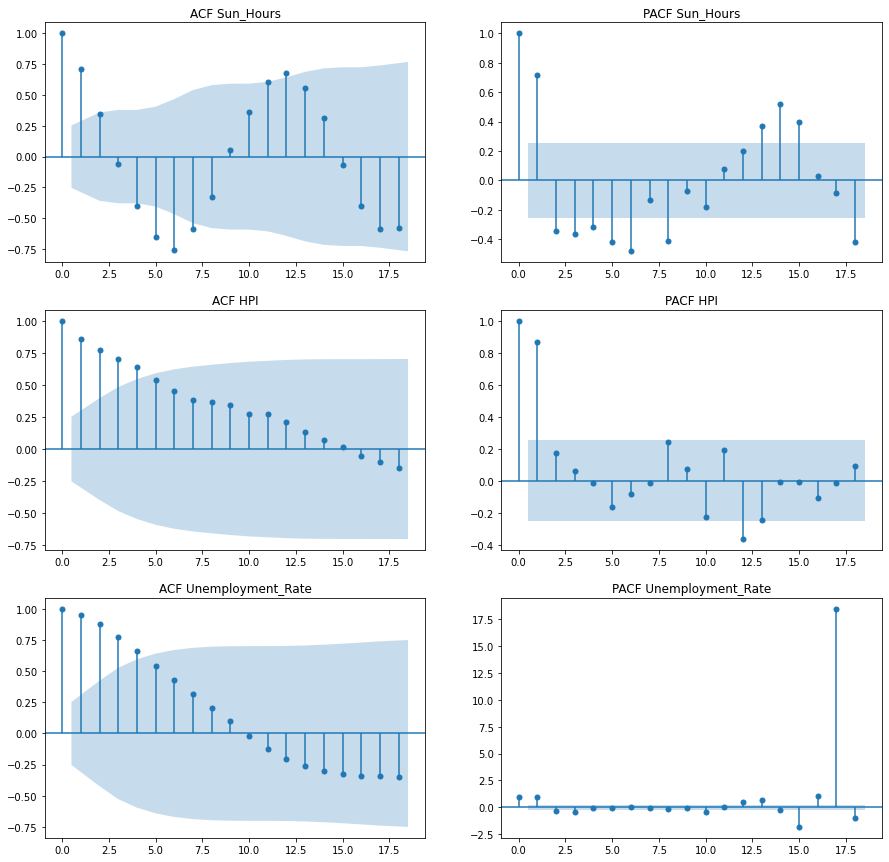

In [11]:
fig,ax = plt.subplots(3,2,figsize=(15,15))
plot_acf(df['Sun_Hours'],title='ACF Sun_Hours',ax=ax[0,0])
plot_pacf(df['Sun_Hours'],title='PACF Sun_Hours',ax=ax[0,1])

plot_acf(df['HPI'],title='ACF HPI',ax=ax[1,0])
plot_pacf(df['HPI'],title='PACF HPI',ax=ax[1,1])

plot_acf(df['Unemployment_Rate'],title='ACF Unemployment_Rate',ax=ax[2,0])
plot_pacf(df['Unemployment_Rate'],title='PACF Unemployment_Rate',ax=ax[2,1])
plt.gcf().set_facecolor('white');

## Check correlation

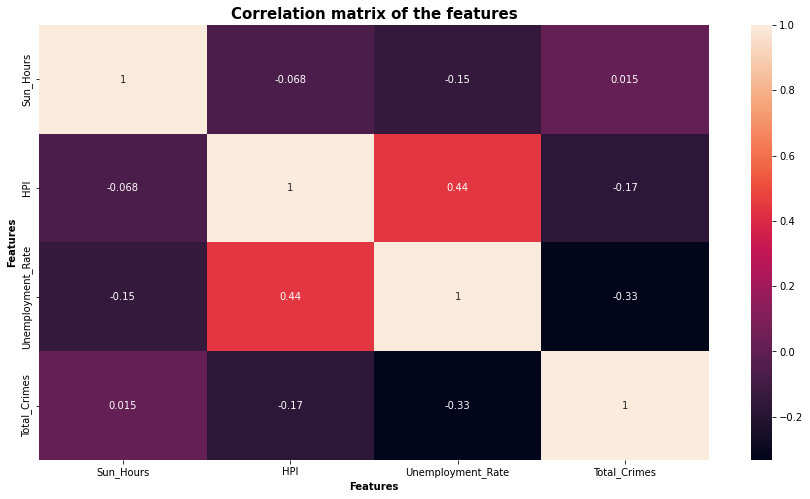

In [12]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True)
plt.xlabel("Features",weight='bold')
plt.ylabel('Features',weight='bold')
plt.title('Correlation matrix of the features',size=15,weight='bold');

# Create train and test sets and perform MinMax scaling 

In [13]:
df.Month = pd.to_datetime(df.Month)
scaler = MinMaxScaler()


X_train = scaler.fit_transform(df[df.Month.dt.year <= 2020].iloc[:,1:-1])
X_test = scaler.fit_transform(df[df.Month.dt.year == 2021].iloc[:,1:-1])

y_train = df[df.Month.dt.year <= 2020]['Total_Crimes'].values
y_test = df[df.Month.dt.year == 2021]['Total_Crimes'].values

In [14]:
n_steps = 3
n_features = len(X_train)

#### Preview of the training data
Essentially, the format of the data is [2017 Jan, 2017 Feb, 2017 Mar] as X values and the corresponding Y value is 2017 April. And the next row is [2017 May,Jun, July] and the corresponding Y value is 2017 August. \
**The values below are scaled values of the original crime data.**

In [15]:
for i in range(5):
    print(X_train[i],y_train[i])

[0.08433735 0.38823529 0.57142857] 144
[0.07228916 0.4248366  0.57142857] 166
[0.28915663 0.38300654 0.5       ] 194
[0.55421687 0.52418301 0.42857143] 169
[0.59036145 0.56078431 0.42857143] 169


# Models

### Baseline

In [16]:
# create any cache and set seed to obtain uniform results
tf.keras.backend.clear_session()
tf.random.set_seed(51)

# build the model
baseline = tf.keras.models.Sequential([
        # transform dataset to correct dimensions
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),      
        # lstm layers followed by dropout
        tf.keras.layers.LSTM(50,activation='relu', input_shape=[n_steps, n_features]),
        # dense layer
        tf.keras.layers.Dense(1)])

baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Bidirectional LSTM

In [17]:
# create any cache and set seed to obtain uniform results
tf.keras.backend.clear_session()
tf.random.set_seed(51)

# build the model
bidirectional = tf.keras.models.Sequential([

        # transform dataset to correct dimensions
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),  
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])

input_shape=(None,)
bidirectional.build(input_shape)
bidirectional.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

### CNN LSTM

In [18]:
# create any cache and set seed to obtain uniform results
tf.keras.backend.clear_session()
tf.random.set_seed(51)


cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None,1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 64)          24832     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

# Training process

In [19]:
def train_model(model, epochs=100, verbose=False, label=str):
    # automatically updates the optimizer learning rate every epoch
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-8 * 10**(epoch/20))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[lr_schedule], verbose=verbose)
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'],color='blue')
    plt.title('{} Model: Loss per Epoch'.format(label),weight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['val_loss'], color='orange')
    plt.legend(['Train Loss','Test Loss'])

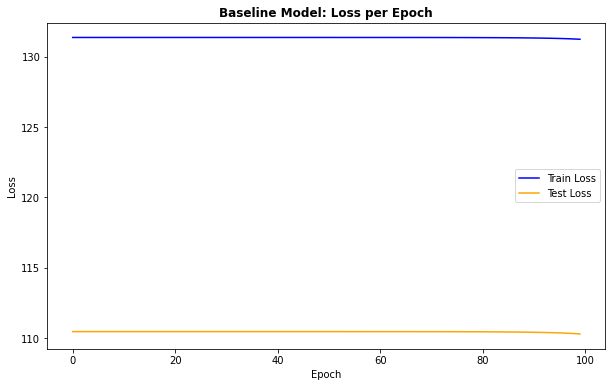

In [20]:
train_model(baseline,label='Baseline')

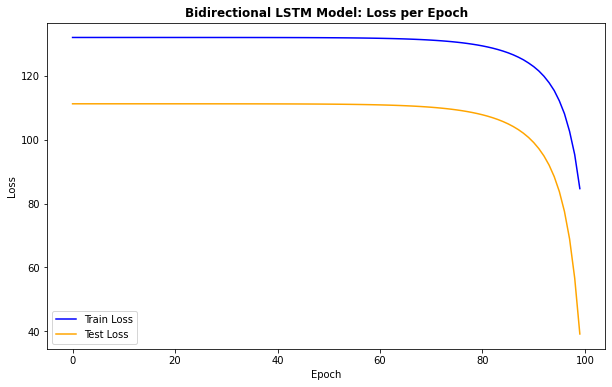

In [21]:
train_model(bidirectional, label='Bidirectional LSTM')

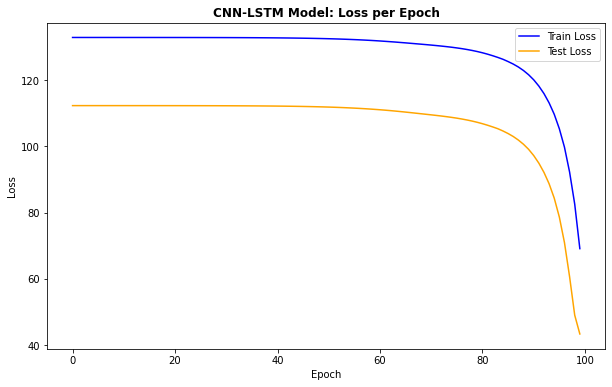

In [22]:
train_model(cnn, label='CNN-LSTM')

# Evaluating the models

### Evaluation Metrics

In [23]:
from sklearn.metrics import r2_score

# define metrics functions
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def rmse(y_true, y_pred):
	return np.sqrt(mean_squared_error(y_pred,y_true))

### Function for testing

In [24]:
def test_model(models, X_test,y_test):
    '''
    Input:  list of models to evaluate
    Output: loss, mae, rmse on test set
    '''
    score = []
    loss= []
    mae= []
    rmse_list=[]
    for i in models:
        score = i.evaluate(X_test, y_test,verbose=0)
        loss.append(np.round(score[0],3))
        mae.append(np.round(score[1],3))
        rmse_list.append(np.round(rmse(y_test, i.predict(X_test)),3))
#         r2_list.append(np.round(r2_score(y_test, i.predict(X_test)),3))
    return loss, mae, rmse_list
        

In [25]:
models=[baseline, bidirectional,cnn]
loss, mae, rmse_list = test_model(models,X_test,y_test)
print(y_test.shape, baseline.predict(X_test).shape)
print(y_test.shape, bidirectional.predict(X_test).shape)
print(y_test.shape, cnn.predict(X_test).shape)

r2_list = [np.round(r2_score(y_test, baseline.predict(X_test)),3),
          np.round(r2_score(y_test, bidirectional.predict(X_test)),3),
          0]
#print(cnn.predict(X_test)) # each prediction has 3 values?

(12,) (12, 1)
(12,) (12, 1)
(12,) (12, 3, 1)


In [26]:
m = ['Baseline', 'Bidirectional-LSTM','CNN-LSTM']
results = pd.DataFrame({'Model': m, 'Test_Loss':loss, 'MAE':mae,'RMSE':rmse_list, 'R2':r2_list})
results

,Model,Test_Loss,MAE,RMSE,R2
0,Baseline,110.282,110.782,114.542,-14.485
1,Bidirectional-LSTM,39.192,39.689,50.104,-1.733
2,CNN-LSTM,43.347,43.845,52.623,0.000


### Visualise the results

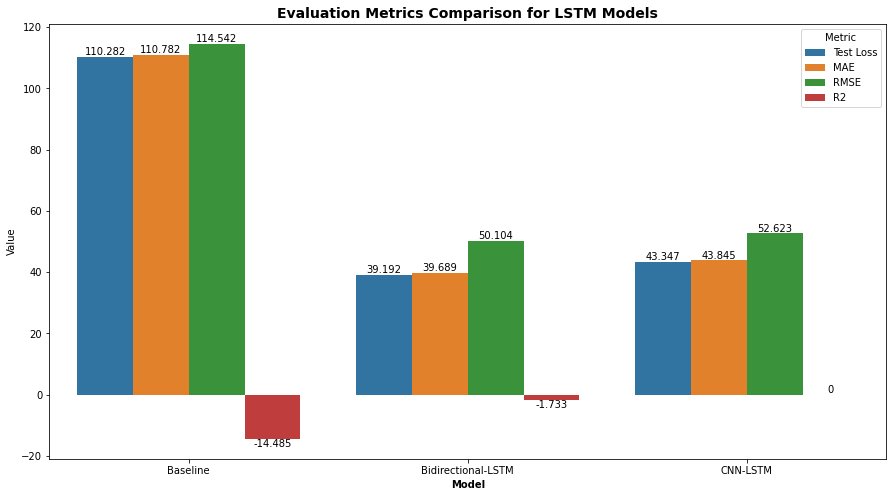

In [27]:
test_results = pd.DataFrame(zip(m*4, ["Test Loss"]*3+["MAE"]*3+["RMSE"]*3+["R2"]*3, loss+mae+rmse_list+r2_list), columns=["Model", "Metric", "Value"])
plt.figure(figsize=(15, 8))
ax = sns.barplot(x="Model", hue="Metric", y="Value", data=test_results,palette='tab10')
ax.set_title('Evaluation Metrics Comparison for LSTM Models',weight='bold',size=14)
ax.set_xlabel('Model',weight='bold',size=10)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

### Evaluating with 2021 data


In [28]:
def plot_predictions(model, label=str):
    
    y_true = y_test
    y_hat = model.predict(X_test)

    # plot the true and predicted values
    fig, ax = plt.subplots(1,figsize=(10,6))
    
    
    ax.set_title('{} Model Predictions'.format(label),weight='bold',size=14)
    ax.set_xticklabels(df[df.Month.dt.year==2021]['Month'],rotation=90)
    
    #plt.xlabel('Index of Values')
    plt.ylabel('Number of crimes')
    plt.plot(y_true,label='True Values')
    plt.plot(y_hat,label='Predicted Values')
    plt.legend(loc='best')
    plt.gcf().set_facecolor('white');

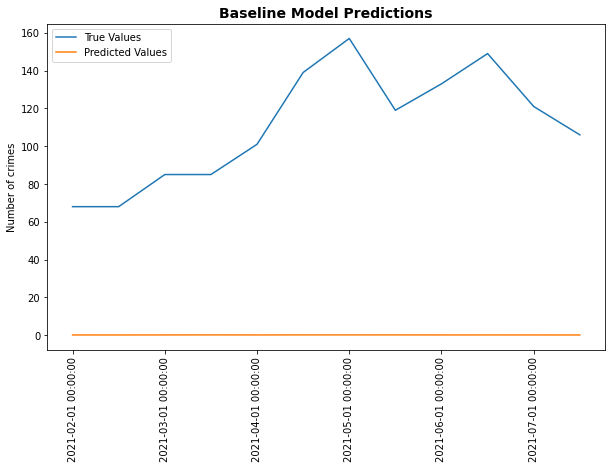

In [29]:
plot_predictions(baseline,label='Baseline')

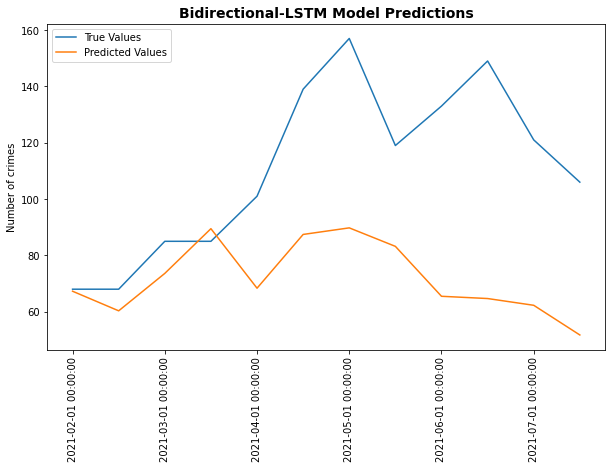

In [30]:
plot_predictions(bidirectional,label='Bidirectional-LSTM')